In [1]:
# ============================================
# Step 1: Upload dataset
# ============================================
from google.colab import files
import zipfile, os
uploaded = files.upload()   # this will allow me to upload the dataset because i am working on colab
zip_path = list(uploaded.keys())[0]
extract_dir = "/content"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)
print("Extracted files to:", extract_dir)
!ls -R $extract_dir | head -n 50


Saving DL_Assignment1_Dataset.zip to DL_Assignment1_Dataset.zip
Extracted files to: /content
/content:
Dataset
DL_Assignment1_Dataset.zip
sample_data

/content/Dataset:
Dataset

/content/Dataset/Dataset:
annotations
images

/content/Dataset/Dataset/annotations:
0_aro.npy
0_exp.npy
0_lnd.npy
0_val.npy
1001_aro.npy
1001_exp.npy
1001_lnd.npy
1001_val.npy
1002_aro.npy
1002_exp.npy
1002_lnd.npy
1002_val.npy
1003_aro.npy
1003_exp.npy
1003_lnd.npy
1003_val.npy
1007_aro.npy
1007_exp.npy
1007_lnd.npy
1007_val.npy
1008_aro.npy
1008_exp.npy
1008_lnd.npy
1008_val.npy
1009_aro.npy
1009_exp.npy
1009_lnd.npy
1009_val.npy
100_aro.npy
100_exp.npy
100_lnd.npy
100_val.npy
1010_aro.npy
1010_exp.npy
1010_lnd.npy
1010_val.npy
1011_aro.npy


In [2]:
# ============================================
# Step 2: Imports and Config
# ============================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

#Charts and visualizations ka breakdown
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEADS = 20
EPOCHS_FINE = 15
#using heads and fine seperately taake pehle model apne se new layers mn learn kre. uske baad full model with the pretrained train kiya jaye
training_history = {}
model_results = {}

In [5]:
# ============================================
# Step 3: Load Annotations
# ============================================
import re
from glob import glob
import os

#Colab ke hisab se khata
IMG_DIR = "/content/Dataset/Dataset/images"
ANNOT_DIR = "/content/Dataset/Dataset/annotations"

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(ANNOT_DIR, exist_ok=True)
print("Looking for data in:")
print(f"Images: {IMG_DIR}")
print(f"Annotations: {ANNOT_DIR}")

if os.path.exists(IMG_DIR) and os.path.exists(ANNOT_DIR):
    img_files = glob(os.path.join(IMG_DIR, "*.jpg"))
    exp_files = glob(os.path.join(ANNOT_DIR, "*_exp.npy"))
    print(f"Found {len(img_files)} images and {len(exp_files)} expression files")
else:
    print("Directories not found. Please check your dataset structure.")
    print("Expected structure:")
    print("  /content/images/*.jpg")
    print("  /content/annotations/*_exp.npy, *_val.npy, *_aro.npy")

records = []
if os.path.exists(ANNOT_DIR):
    for exp_file in glob(os.path.join(ANNOT_DIR, "*_exp.npy")):
        img_id = re.findall(r"(\d+)_exp.npy", os.path.basename(exp_file))
        if not img_id:
            continue
        img_id = img_id[0]
        img_file = os.path.join(IMG_DIR, f"{img_id}.jpg")
        val_file = os.path.join(ANNOT_DIR, f"{img_id}_val.npy")
        aro_file = os.path.join(ANNOT_DIR, f"{img_id}_aro.npy")

        if os.path.exists(img_file) and os.path.exists(val_file) and os.path.exists(aro_file):
            exp = int(np.load(exp_file))
            val = float(np.load(val_file))
            aro = float(np.load(aro_file))
            if val != -2 and aro != -2:
                records.append((img_file, exp, val, aro))

df = pd.DataFrame(records, columns=["image", "expression", "valence", "arousal"])
print("Dataset size:", len(df))

if len(df) > 0:
    print("\nDataset Statistics:")
    print(f"Expression distribution:\n{df['expression'].value_counts().sort_index()}")
    print(f"Valence range: {df['valence'].min():.3f} to {df['valence'].max():.3f}")
    print(f"Arousal range: {df['arousal'].min():.3f} to {df['arousal'].max():.3f}")
else:
    print("No data loaded. Please check your dataset paths and structure.")


Looking for data in:
Images: /content/Dataset/Dataset/images
Annotations: /content/Dataset/Dataset/annotations
Found 3999 images and 3999 expression files
Dataset size: 3999

Dataset Statistics:
Expression distribution:
expression
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    499
Name: count, dtype: int64
Valence range: -0.987 to 0.982
Arousal range: -0.667 to 0.984


In [16]:
# ============================================
# Step 4: Split dataset
# ============================================
#80/20 split hai. no testing because validation paramters reuired
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["expression"])


In [7]:

# ============================================
# Step 5: ImageDataGenerator
# ============================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased for better augmentation
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

num_classes = df["expression"].nunique()
train_df["expression_cat"] = to_categorical(train_df["expression"], num_classes=num_classes).tolist()
val_df["expression_cat"] = to_categorical(val_df["expression"], num_classes=num_classes).tolist()

def generator(df, datagen):
    while True:
        for start in range(0, len(df), BATCH_SIZE):
            end = min(start + BATCH_SIZE, len(df))
            batch_df = df[start:end]
            X = np.array([tf.keras.preprocessing.image.img_to_array(
                tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE))/255.0
                          for p in batch_df["image"]])
            y_expr = np.array(batch_df["expression_cat"].tolist())
            y_val = np.array(batch_df["valence"].tolist())
            y_aro = np.array(batch_df["arousal"].tolist())
            yield X, {"expression": y_expr, "valence": y_val, "arousal": y_aro}

train_ds = generator(train_df, train_datagen)
val_ds = generator(val_df, val_datagen)

steps_train = len(train_df) // BATCH_SIZE
steps_val = len(val_df) // BATCH_SIZE


In [8]:
# ============================================
# Step 6: Build Model
# ============================================
def build_model(backbone_name="EfficientNetB0", num_classes=8):
    inputs = Input(shape=(224, 224, 3))
    if backbone_name == "EfficientNetB0":
        backbone = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")
    elif backbone_name == "ResNet50":
        backbone = ResNet50(include_top=False, weights="imagenet", pooling="avg")
    else:
        raise ValueError(f"Unsupported backbone: {backbone_name}")
    x = backbone(inputs)

    if backbone_name == "EfficientNetB0":
        x_expr = layers.Dense(512, activation="relu")(x)
        x_expr = layers.BatchNormalization()(x_expr)
        x_expr = layers.Dropout(0.5)(x_expr)  # Increased dropout to prevent overfitting
        x_expr = layers.Dense(256, activation="relu")(x_expr)
        x_expr = layers.BatchNormalization()(x_expr)
        x_expr = layers.Dropout(0.4)(x_expr)  # Increased dropout
        x_expr = layers.Dense(128, activation="relu")(x_expr)
        x_expr = layers.BatchNormalization()(x_expr)
        x_expr = layers.Dropout(0.3)(x_expr)  # Increased dropout
        expr_out = layers.Dense(num_classes, activation="softmax", name="expression")(x_expr)

        # Moderate regression heads for EfficientNet
        x_val = layers.Dense(64, activation="relu")(x)
        x_val = layers.Dropout(0.3)(x_val)
        val_out = layers.Dense(1, activation="tanh", name="valence")(x_val)

        x_aro = layers.Dense(64, activation="relu")(x)
        x_aro = layers.Dropout(0.3)(x_aro)
        aro_out = layers.Dense(1, activation="tanh", name="arousal")(x_aro)

    else:  # ResNet50
        # Moderate regularization for ResNet - allow learning but prevent overfitting
        x_expr = layers.Dense(512, activation="relu")(x)
        x_expr = layers.BatchNormalization()(x_expr)
        x_expr = layers.Dropout(0.5)(x_expr)  # Reduced dropout for better learning
        x_expr = layers.Dense(256, activation="relu")(x_expr)
        x_expr = layers.BatchNormalization()(x_expr)
        x_expr = layers.Dropout(0.4)(x_expr)  # Reduced dropout
        x_expr = layers.Dense(128, activation="relu")(x_expr)
        x_expr = layers.BatchNormalization()(x_expr)
        x_expr = layers.Dropout(0.3)(x_expr)  # Reduced dropout
        expr_out = layers.Dense(num_classes, activation="softmax", name="expression")(x_expr)

        # Moderate regression heads for ResNet
        x_val = layers.Dense(64, activation="relu")(x)
        x_val = layers.Dropout(0.3)(x_val)
        val_out = layers.Dense(1, activation="tanh", name="valence")(x_val)

        x_aro = layers.Dense(64, activation="relu")(x)
        x_aro = layers.Dropout(0.3)(x_aro)
        aro_out = layers.Dense(1, activation="tanh", name="arousal")(x_aro)

    model = models.Model(inputs=inputs, outputs=[expr_out, val_out, aro_out])
    model.backbone = backbone
    return model

In [9]:
# ============================================
# Step 6.5: Evaluation Metrics Functions
# ============================================

def calculate_categorical_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Calculate all categorical evaluation metrics
    """
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred)

    # Krippendorff's Alpha (approximation using ICC)
    try:
        from scipy.stats import pearsonr
        # Simple approximation - in practice, use proper ICC calculation
        metrics['krippendorff_alpha'] = cohen_kappa_score(y_true, y_pred)
    except:
        metrics['krippendorff_alpha'] = 0.0

    # AUC metrics (if probabilities available)
    if y_pred_proba is not None:
        try:
            metrics['auc'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
            metrics['auc_pr'] = average_precision_score(y_true, y_pred_proba, average='weighted')
        except:
            metrics['auc'] = 0.0
            metrics['auc_pr'] = 0.0
    else:
        metrics['auc'] = 0.0
        metrics['auc_pr'] = 0.0

    return metrics

def calculate_continuous_metrics(y_true, y_pred):
    """
    Calculate all continuous evaluation metrics
    """
    metrics = {}

    # RMSE
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))

    # Correlation
    corr, _ = pearsonr(y_true, y_pred)
    metrics['correlation'] = corr if not np.isnan(corr) else 0.0

    # Sign Agreement Metric (SAGR)
    sign_agreement = np.mean(np.sign(y_true) == np.sign(y_pred))
    metrics['sagr'] = sign_agreement

    # Concordance Correlation Coefficient (CCC)
    # CCC = (2 * r * σx * σy) / (σx² + σy² + (μx - μy)²)
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.cov(y_true, y_pred)[0, 1]

    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred)**2)
    metrics['ccc'] = ccc if not np.isnan(ccc) else 0.0

    return metrics

def evaluate_model(model, test_data, test_labels):
    """
    Comprehensive model evaluation
    """
    print("Evaluating model...")

    # Get predictions
    predictions = model.predict(test_data)
    expr_pred_proba = predictions[0]
    expr_pred = np.argmax(expr_pred_proba, axis=1)
    val_pred = predictions[1].flatten()
    aro_pred = predictions[2].flatten()

    # Extract true labels
    expr_true = test_labels['expression']
    val_true = test_labels['valence']
    aro_true = test_labels['arousal']

    # Calculate metrics
    expr_metrics = calculate_categorical_metrics(expr_true, expr_pred, expr_pred_proba)
    val_metrics = calculate_continuous_metrics(val_true, val_pred)
    aro_metrics = calculate_continuous_metrics(aro_true, aro_pred)

    return {
        'expression': expr_metrics,
        'valence': val_metrics,
        'arousal': aro_metrics,
        'predictions': {
            'expression': expr_pred,
            'valence': val_pred,
            'arousal': aro_pred
        }
    }

def plot_training_history(history, model_name):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} Training History', fontsize=16)

    # Expression accuracy
    axes[0, 0].plot(history.history['expression_accuracy'], label='Training')
    axes[0, 0].plot(history.history['val_expression_accuracy'], label='Validation')
    axes[0, 0].set_title('Expression Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Expression loss
    axes[0, 1].plot(history.history['expression_loss'], label='Training')
    axes[0, 1].plot(history.history['val_expression_loss'], label='Validation')
    axes[0, 1].set_title('Expression Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Valence loss
    axes[1, 0].plot(history.history['valence_loss'], label='Training')
    axes[1, 0].plot(history.history['val_valence_loss'], label='Validation')
    axes[1, 0].set_title('Valence Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Arousal loss
    axes[1, 1].plot(history.history['arousal_loss'], label='Training')
    axes[1, 1].plot(history.history['val_arousal_loss'], label='Validation')
    axes[1, 1].set_title('Arousal Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def create_results_summary(model_results):
    """
    Create a comprehensive results summary
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION RESULTS")
    print("="*80)

    for model_name, results in model_results.items():
        print(f"\n{model_name.upper()} RESULTS:")
        print("-" * 50)

        # Expression metrics
        print("EXPRESSION CLASSIFICATION:")
        expr_metrics = results['expression']
        for metric, value in expr_metrics.items():
            print(f"  {metric.upper()}: {value:.4f}")

        # Valence metrics
        print("\nVALENCE REGRESSION:")
        val_metrics = results['valence']
        for metric, value in val_metrics.items():
            print(f"  {metric.upper()}: {value:.4f}")

        # Arousal metrics
        print("\nAROUSAL REGRESSION:")
        aro_metrics = results['arousal']
        for metric, value in aro_metrics.items():
            print(f"  {metric.upper()}: {value:.4f}")

    # Comparison table
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)

    comparison_data = []
    for model_name, results in model_results.items():
        row = {
            'Model': model_name,
            'Expression Accuracy': results['expression']['accuracy'],
            'Expression F1': results['expression']['f1_score'],
            'Valence RMSE': results['valence']['rmse'],
            'Valence Correlation': results['valence']['correlation'],
            'Arousal RMSE': results['arousal']['rmse'],
            'Arousal Correlation': results['arousal']['correlation']
        }
        comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    return comparison_df


✅ Dataset loaded successfully: 3999 samples

🚀 TRAINING EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
📊 Training Configuration:
   - Heads epochs: 15
   - Fine-tune epochs: 12
   - Initial LR: 0.00015
   - Fine-tune LR: 3e-05
   - Loss weights: {'expression': 2.5, 'valence': 1.0, 'arousal': 1.0}

🔧 Phase 1: Training heads only...
Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - arousal_loss: 0.1645 - expression_accuracy: 0.1350 - expression_loss: 2.8495 - loss: 7.5476 - valence_loss: 0.2593

99/99 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - arousal_loss: 0.1644 - expression_accuracy: 0.1350 - expression_loss: 2.8494 - loss: 7.5470 - valence_loss: 0.2591 - val_arousal_loss: 0.1446 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.1175 - val_loss: 5.6599 - val_valence_loss: 0.2216 - learning_rate: 1.5000e-04
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - arousal_loss: 0.1474 - expression_accuracy: 0.1190 - expression_loss: 2.7538 - loss: 7.2514 - valence_loss: 0.2206 - val_arousal_loss: 0.1446 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.1125 - val_loss: 5.6524 - val_valence_loss: 0.2265 - learning_rate: 1.5000e-04
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - arousal_loss: 0.1482 - expression_accuracy: 0.1191 - expression_loss: 2.7561 - loss: 7.2552 - valence_loss: 0.2173 - val_arousal_loss: 0.1446 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.1401 - val_loss: 5.7182 - val_valence_loss: 0.2233 - learning_rate: 1.5000e-04
Epoch 4/1

99/99 ━━━━━━━━━━━━━━━━━━━━ 102s 224ms/step - arousal_loss: 0.2646 - expression_accuracy: 0.1192 - expression_loss: 2.9710 - loss: 8.1340 - valence_loss: 0.4420 - val_arousal_loss: 0.1462 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.1487 - val_loss: 5.7584 - val_valence_loss: 0.2405 - learning_rate: 3.0000e-05
Epoch 2/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 143ms/step - arousal_loss: 0.2032 - expression_accuracy: 0.1411 - expression_loss: 2.8451 - loss: 7.6281 - valence_loss: 0.3140 - val_arousal_loss: 0.1975 - val_expression_accuracy: 0.1225 - val_expression_loss: 2.1529 - val_loss: 5.8477 - val_valence_loss: 0.2680 - learning_rate: 3.0000e-05
Epoch 3/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - arousal_loss: 0.1970 - expression_accuracy: 0.1540 - expression_loss: 2.7220 - loss: 7.2791 - valence_loss: 0.2773 - val_arousal_loss: 0.1808 - val_expression_accuracy: 0.1213 - val_expression_loss: 2.2253 - val_loss: 6.0168 - val_valence_loss: 0.2728 - learning_rate: 3.0000e-05
Epoch

99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - arousal_loss: 0.1712 - expression_accuracy: 0.1657 - expression_loss: 2.6535 - loss: 7.0486 - valence_loss: 0.2440 - val_arousal_loss: 0.2395 - val_expression_accuracy: 0.1312 - val_expression_loss: 2.2549 - val_loss: 6.1234 - val_valence_loss: 0.2467 - learning_rate: 3.0000e-05
Epoch 6/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - arousal_loss: 0.1649 - expression_accuracy: 0.1502 - expression_loss: 2.5946 - loss: 6.8831 - valence_loss: 0.2314 - val_arousal_loss: 0.2104 - val_expression_accuracy: 0.1175 - val_expression_loss: 2.3139 - val_loss: 6.2397 - val_valence_loss: 0.2444 - learning_rate: 3.0000e-05
Epoch 7/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - arousal_loss: 0.1557 - expression_accuracy: 0.1874 - expression_loss: 2.5173 - loss: 6.6682 - valence_loss: 0.2197 - val_arousal_loss: 0.1884 - val_expression_accuracy: 0.1275 - val_expression_loss: 2.2628 - val_loss: 6.1090 - val_valence_loss: 0.2635 - learning_rate: 3.0000e-05
Epoch 

99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - arousal_loss: 0.1452 - expression_accuracy: 0.1871 - expression_loss: 2.5329 - loss: 6.6950 - valence_loss: 0.2180 - val_arousal_loss: 0.2172 - val_expression_accuracy: 0.1450 - val_expression_loss: 2.2339 - val_loss: 6.0542 - val_valence_loss: 0.2522 - learning_rate: 3.0000e-05
Epoch 9/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - arousal_loss: 0.1513 - expression_accuracy: 0.1989 - expression_loss: 2.4190 - loss: 6.3954 - valence_loss: 0.1963 - val_arousal_loss: 0.1682 - val_expression_accuracy: 0.1225 - val_expression_loss: 2.3585 - val_loss: 6.3607 - val_valence_loss: 0.2963 - learning_rate: 3.0000e-05
Epoch 10/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - arousal_loss: 0.1478 - expression_accuracy: 0.2212 - expression_loss: 2.3231 - loss: 6.1531 - valence_loss: 0.1977 - val_arousal_loss: 0.1942 - val_expression_accuracy: 0.1013 - val_expression_loss: 2.5362 - val_loss: 6.8181 - val_valence_loss: 0.2835 - learning_rate: 3.0000e-05
Epoch

99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - arousal_loss: 0.1396 - expression_accuracy: 0.2242 - expression_loss: 2.2835 - loss: 6.0291 - valence_loss: 0.1809 - val_arousal_loss: 0.1774 - val_expression_accuracy: 0.1587 - val_expression_loss: 2.2147 - val_loss: 5.9817 - val_valence_loss: 0.2676 - learning_rate: 3.0000e-05

✅ EfficientNetB0 training completed!


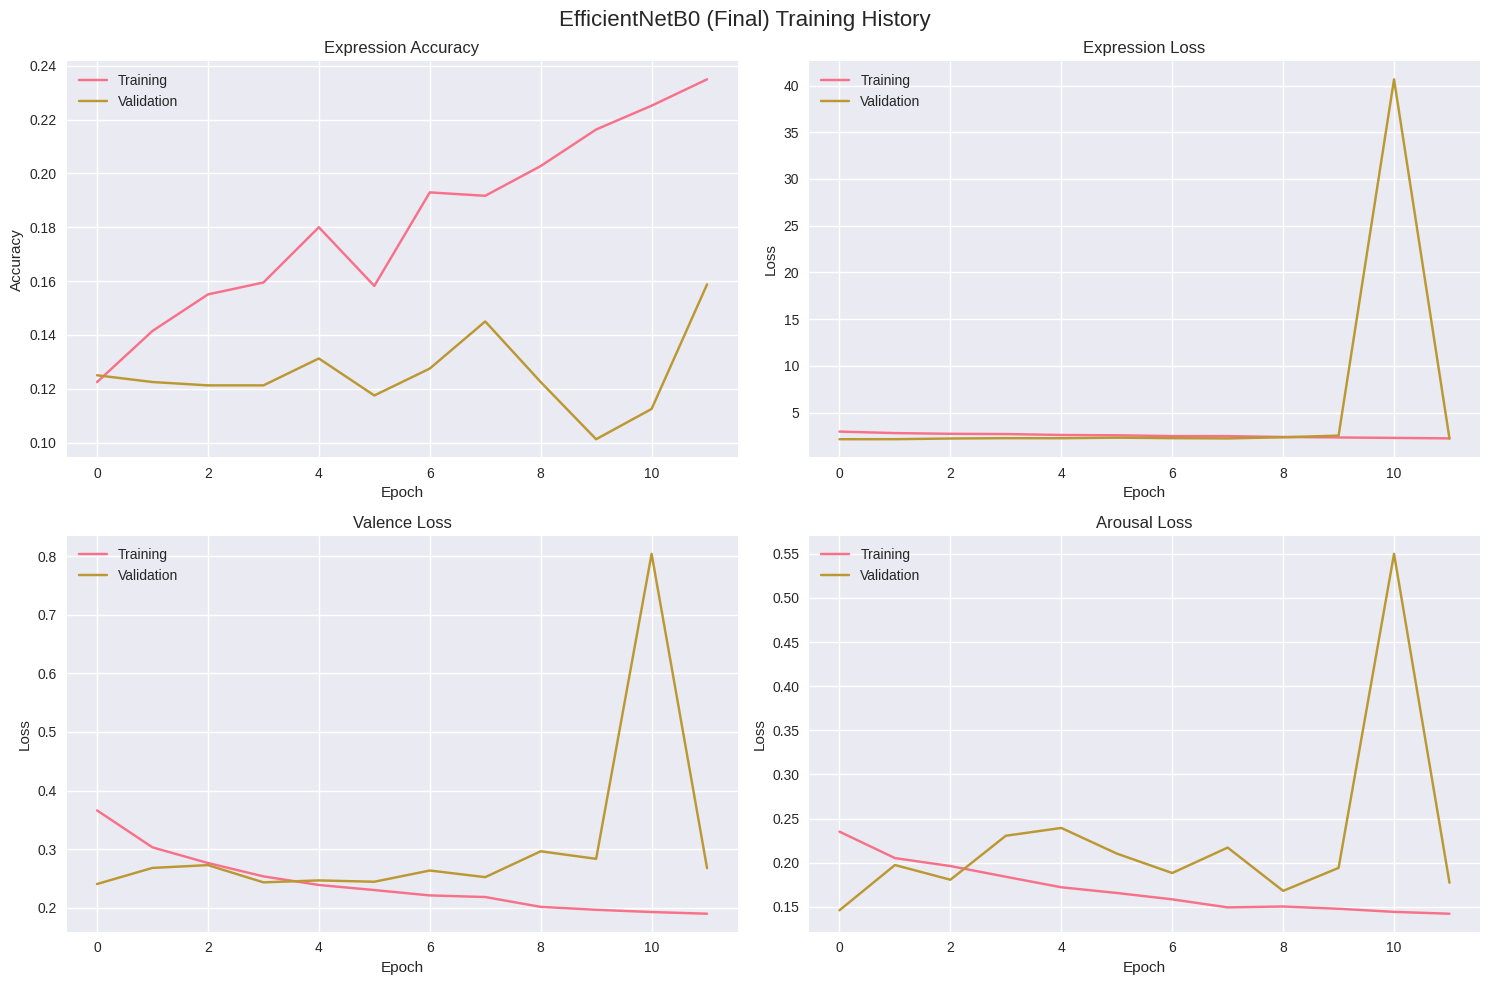


🚀 TRAINING ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
📊 Training Configuration:
   - Heads epochs: 12
   - Fine-tune epochs: 12
   - Initial LR: 0.00015
   - Fine-tune LR: 2e-05
   - Loss weights: {'expression': 2.0, 'valence': 1.0, 'arousal': 1.0}

🔧 Phase 1: Training heads only...
Epoch 1/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - arousal_loss: 0.3666 - expression_accuracy: 0.1252 - expression_loss: 2.8767 - loss: 6.5100 - valence_loss: 0.3892

99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 271ms/step - arousal_loss: 0.3658 - expression_accuracy: 0.1252 - expression_loss: 2.8764 - loss: 6.5079 - valence_loss: 0.3886 - val_arousal_loss: 0.1479 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.1273 - val_loss: 4.6274 - val_valence_loss: 0.2249 - learning_rate: 1.5000e-04
Epoch 2/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - arousal_loss: 0.1668 - expression_accuracy: 0.1457 - expression_loss: 2.6560 - loss: 5.7056 - valence_loss: 0.2262

99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - arousal_loss: 0.1667 - expression_accuracy: 0.1458 - expression_loss: 2.6561 - loss: 5.7057 - valence_loss: 0.2262 - val_arousal_loss: 0.1451 - val_expression_accuracy: 0.1325 - val_expression_loss: 2.1529 - val_loss: 4.6759 - val_valence_loss: 0.2250 - learning_rate: 1.5000e-04
Epoch 3/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - arousal_loss: 0.1450 - expression_accuracy: 0.1598 - expression_loss: 2.5911 - loss: 5.5472 - valence_loss: 0.2200 - val_arousal_loss: 0.1462 - val_expression_accuracy: 0.1262 - val_expression_loss: 2.1423 - val_loss: 4.6551 - val_valence_loss: 0.2242 - learning_rate: 1.5000e-04
Epoch 4/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - arousal_loss: 0.1425 - expression_accuracy: 0.1638 - expression_loss: 2.5640 - loss: 5.4891 - valence_loss: 0.2181

99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - arousal_loss: 0.1426 - expression_accuracy: 0.1638 - expression_loss: 2.5637 - loss: 5.4884 - valence_loss: 0.2181 - val_arousal_loss: 0.1468 - val_expression_accuracy: 0.1650 - val_expression_loss: 2.2040 - val_loss: 4.7777 - val_valence_loss: 0.2229 - learning_rate: 1.5000e-04
Epoch 5/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - arousal_loss: 0.1438 - expression_accuracy: 0.1724 - expression_loss: 2.4803 - loss: 5.3221 - valence_loss: 0.2178 - val_arousal_loss: 0.1448 - val_expression_accuracy: 0.1550 - val_expression_loss: 2.1506 - val_loss: 4.6695 - val_valence_loss: 0.2234 - learning_rate: 1.5000e-04
Epoch 6/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - arousal_loss: 0.1399 - expression_accuracy: 0.1521 - expression_loss: 2.4323 - loss: 5.2223 - valence_loss: 0.2174 - val_arousal_loss: 0.1434 - val_expression_accuracy: 0.1538 - val_expression_loss: 2.1359 - val_loss: 4.6347 - val_valence_loss: 0.2197 - learning_rate: 1.5000e-04
Epoch 

99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - arousal_loss: 0.1414 - expression_accuracy: 0.1738 - expression_loss: 2.3659 - loss: 5.0933 - valence_loss: 0.2197 - val_arousal_loss: 0.1429 - val_expression_accuracy: 0.1925 - val_expression_loss: 2.1004 - val_loss: 4.5690 - val_valence_loss: 0.2254 - learning_rate: 6.0000e-05
Epoch 9/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - arousal_loss: 0.1434 - expression_accuracy: 0.1686 - expression_loss: 2.3652 - loss: 5.0885 - valence_loss: 0.2149 - val_arousal_loss: 0.1421 - val_expression_accuracy: 0.1912 - val_expression_loss: 2.0976 - val_loss: 4.5630 - val_valence_loss: 0.2257 - learning_rate: 6.0000e-05
Epoch 10/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - arousal_loss: 0.1428 - expression_accuracy: 0.1780 - expression_loss: 2.3103 - loss: 4.9793 - valence_loss: 0.2158 - val_arousal_loss: 0.1433 - val_expression_accuracy: 0.1887 - val_expression_loss: 2.1316 - val_loss: 4.6329 - val_valence_loss: 0.2263 - learning_rate: 6.0000e-05
Epoch

99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - arousal_loss: 0.1427 - expression_accuracy: 0.1791 - expression_loss: 2.3052 - loss: 4.9673 - valence_loss: 0.2138 - val_arousal_loss: 0.1432 - val_expression_accuracy: 0.2050 - val_expression_loss: 2.0614 - val_loss: 4.4901 - val_valence_loss: 0.2242 - learning_rate: 2.4000e-05

🔧 Phase 2: Fine-tuning backbone + heads...
Epoch 1/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - arousal_loss: 0.3267 - expression_accuracy: 0.1308 - expression_loss: 2.6200 - loss: 6.0249 - valence_loss: 0.4580

99/99 ━━━━━━━━━━━━━━━━━━━━ 133s 697ms/step - arousal_loss: 0.3263 - expression_accuracy: 0.1308 - expression_loss: 2.6200 - loss: 6.0242 - valence_loss: 0.4577 - val_arousal_loss: 0.2257 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.9995 - val_loss: 6.4485 - val_valence_loss: 0.2239 - learning_rate: 2.0000e-05
Epoch 2/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 316ms/step - arousal_loss: 0.1995 - expression_accuracy: 0.1601 - expression_loss: 2.4540 - loss: 5.4310 - valence_loss: 0.3236 - val_arousal_loss: 0.2413 - val_expression_accuracy: 0.1213 - val_expression_loss: 2.6100 - val_loss: 5.7066 - val_valence_loss: 0.2454 - learning_rate: 2.0000e-05
Epoch 3/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 315ms/step - arousal_loss: 0.1672 - expression_accuracy: 0.2082 - expression_loss: 2.2743 - loss: 4.9577 - valence_loss: 0.2418 - val_arousal_loss: 0.3295 - val_expression_accuracy: 0.1238 - val_expression_loss: 2.6849 - val_loss: 5.9667 - val_valence_loss: 0.2674 - learning_rate: 2.0000e-05
Epoch

99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 391ms/step - arousal_loss: 0.1460 - expression_accuracy: 0.2327 - expression_loss: 2.1604 - loss: 4.6702 - valence_loss: 0.2034 - val_arousal_loss: 0.2410 - val_expression_accuracy: 0.1363 - val_expression_loss: 2.3892 - val_loss: 5.2733 - val_valence_loss: 0.2538 - learning_rate: 2.0000e-05
Epoch 5/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - arousal_loss: 0.1335 - expression_accuracy: 0.2714 - expression_loss: 2.0291 - loss: 4.3783 - valence_loss: 0.1863

99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - arousal_loss: 0.1335 - expression_accuracy: 0.2715 - expression_loss: 2.0289 - loss: 4.3779 - valence_loss: 0.1863 - val_arousal_loss: 0.2052 - val_expression_accuracy: 0.1425 - val_expression_loss: 2.4705 - val_loss: 5.3984 - val_valence_loss: 0.2522 - learning_rate: 2.0000e-05
Epoch 6/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - arousal_loss: 0.1243 - expression_accuracy: 0.3052 - expression_loss: 1.9305 - loss: 4.1519 - valence_loss: 0.1664

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 440ms/step - arousal_loss: 0.1243 - expression_accuracy: 0.3052 - expression_loss: 1.9301 - loss: 4.1512 - valence_loss: 0.1664 - val_arousal_loss: 0.2583 - val_expression_accuracy: 0.1538 - val_expression_loss: 2.6187 - val_loss: 5.7622 - val_valence_loss: 0.2666 - learning_rate: 2.0000e-05
Epoch 7/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 316ms/step - arousal_loss: 0.1202 - expression_accuracy: 0.3230 - expression_loss: 1.8673 - loss: 4.0082 - valence_loss: 0.1533 - val_arousal_loss: 0.2484 - val_expression_accuracy: 0.1225 - val_expression_loss: 2.5475 - val_loss: 5.6604 - val_valence_loss: 0.3171 - learning_rate: 2.0000e-05
Epoch 8/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 316ms/step - arousal_loss: 0.1162 - expression_accuracy: 0.3718 - expression_loss: 1.7301 - loss: 3.7173 - valence_loss: 0.1409 - val_arousal_loss: 0.2217 - val_expression_accuracy: 0.1488 - val_expression_loss: 2.4080 - val_loss: 5.3133 - val_valence_loss: 0.2756 - learning_rate: 2.0000e-05
Epoch 

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - arousal_loss: 0.1132 - expression_accuracy: 0.3944 - expression_loss: 1.6637 - loss: 3.5719 - valence_loss: 0.1311 - val_arousal_loss: 0.1906 - val_expression_accuracy: 0.1700 - val_expression_loss: 2.2387 - val_loss: 4.9355 - val_valence_loss: 0.2675 - learning_rate: 2.0000e-05
Epoch 10/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - arousal_loss: 0.1100 - expression_accuracy: 0.4025 - expression_loss: 1.5852 - loss: 3.3994 - valence_loss: 0.1190

99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 379ms/step - arousal_loss: 0.1099 - expression_accuracy: 0.4027 - expression_loss: 1.5849 - loss: 3.3987 - valence_loss: 0.1189 - val_arousal_loss: 0.1611 - val_expression_accuracy: 0.2225 - val_expression_loss: 1.9958 - val_loss: 4.4058 - val_valence_loss: 0.2530 - learning_rate: 2.0000e-05
Epoch 11/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - arousal_loss: 0.1017 - expression_accuracy: 0.4549 - expression_loss: 1.4833 - loss: 3.1794 - valence_loss: 0.1113

99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - arousal_loss: 0.1016 - expression_accuracy: 0.4550 - expression_loss: 1.4830 - loss: 3.1787 - valence_loss: 0.1113 - val_arousal_loss: 0.1543 - val_expression_accuracy: 0.2463 - val_expression_loss: 1.8909 - val_loss: 4.1626 - val_valence_loss: 0.2265 - learning_rate: 2.0000e-05
Epoch 12/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - arousal_loss: 0.0954 - expression_accuracy: 0.5044 - expression_loss: 1.3888 - loss: 2.9795 - valence_loss: 0.1064

99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 429ms/step - arousal_loss: 0.0954 - expression_accuracy: 0.5044 - expression_loss: 1.3888 - loss: 2.9794 - valence_loss: 0.1064 - val_arousal_loss: 0.1527 - val_expression_accuracy: 0.2800 - val_expression_loss: 1.8329 - val_loss: 4.0230 - val_valence_loss: 0.2045 - learning_rate: 2.0000e-05

✅ ResNet50 training completed!


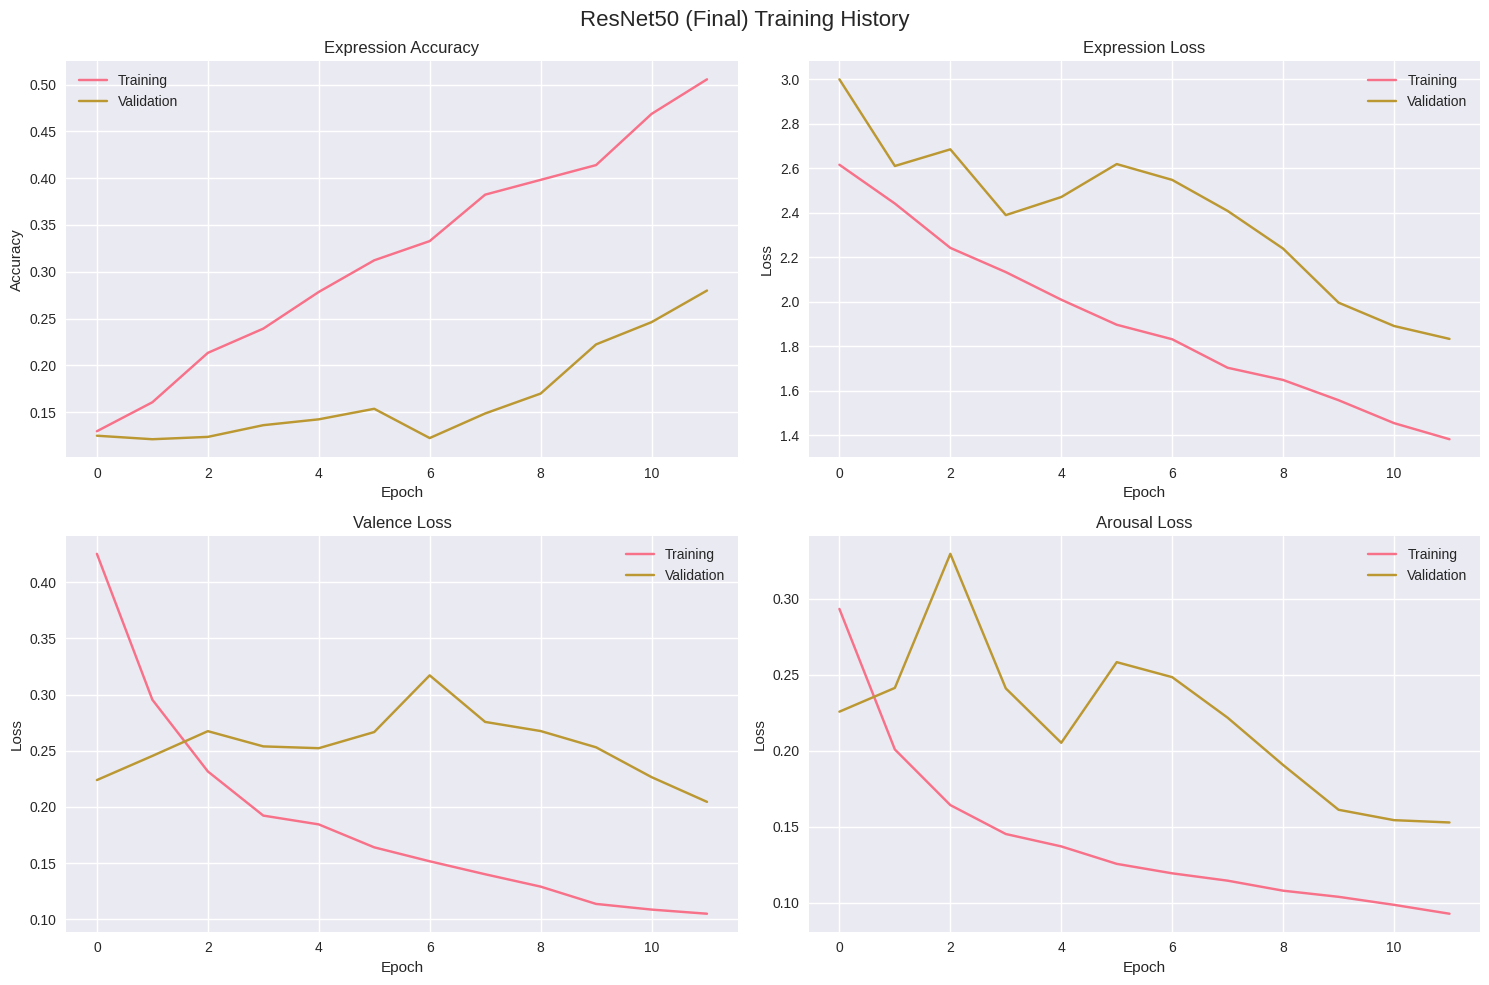

In [10]:
# ============================================
# Step 7 & 8: Training Loop (heads + fine-tune)
# ============================================

# Check if we have data before training
if len(df) == 0:
    print(" No data available for training. Please check your dataset paths.")
    print("Expected dataset structure:")
    print("  /content/images/*.jpg")
    print("  /content/annotations/*_exp.npy, *_val.npy, *_aro.npy")
else:
    print(f" Dataset loaded successfully: {len(df)} samples")

    for backbone_name in ["EfficientNetB0", "ResNet50"]:
        print(f"\n{'='*60}")
        print(f" TRAINING {backbone_name}")
        print(f"{'='*60}")

        model = build_model(backbone_name, num_classes=num_classes)
        backbone_model = model.backbone

        # Different loss weights and training parameters for each model
        if backbone_name == "EfficientNetB0":
            loss_weights = {"expression": 2.5, "valence": 1.0, "arousal": 1.0}  # Moderate weight for expression
            initial_lr = 1.5e-4  # Moderate learning rate to prevent overfitting
            fine_tune_lr = 3e-5  # Moderate fine-tune learning rate
            heads_epochs = 15  # Reduced epochs to prevent overfitting
            fine_epochs = 12  # Reduced fine-tune epochs
        else:  # ResNet50
            loss_weights = {"expression": 2.0, "valence": 1.0, "arousal": 1.0}  # Standard weights
            initial_lr = 1.5e-4  # Increased learning rate for better learning
            fine_tune_lr = 2e-5  # Moderate fine-tune learning rate
            heads_epochs = 12  # Increased epochs for better learning
            fine_epochs = 12  # Moderate fine-tune epochs

        print(f" Training Configuration:")
        print(f"   - Heads epochs: {heads_epochs}")
        print(f"   - Fine-tune epochs: {fine_epochs}")
        print(f"   - Initial LR: {initial_lr}")
        print(f"   - Fine-tune LR: {fine_tune_lr}")
        print(f"   - Loss weights: {loss_weights}")

        # Phase 1: Train heads only
        print(f"\n🔧 Phase 1: Training heads only...")
        backbone_model.trainable = False
        model.compile(
            optimizer=tf.keras.optimizers.Adam(initial_lr),
            loss={"expression": "categorical_crossentropy", "valence": "mse", "arousal": "mse"},
            loss_weights=loss_weights,
            metrics={"expression": "accuracy"}
        )

        # Different callbacks for each model
        if backbone_name == "EfficientNetB0":
            callbacks_heads = [
                ReduceLROnPlateau(monitor="val_expression_accuracy", factor=0.4, patience=3, verbose=1, mode='max'),
                EarlyStopping(monitor="val_expression_accuracy", patience=7, restore_best_weights=True, mode='max'),
                ModelCheckpoint(f"{backbone_name}_heads_best.h5", monitor="val_expression_accuracy", save_best_only=True, mode='max')
            ]
        else:  # ResNet50
            callbacks_heads = [
                ReduceLROnPlateau(monitor="val_expression_accuracy", factor=0.4, patience=3, verbose=1, mode='max'),
                EarlyStopping(monitor="val_expression_accuracy", patience=7, restore_best_weights=True, mode='max'),
                ModelCheckpoint(f"{backbone_name}_heads_best.h5", monitor="val_expression_accuracy", save_best_only=True, mode='max')
            ]

        history_heads = model.fit(
            train_ds,
            validation_data=val_ds,
            steps_per_epoch=steps_train,
            validation_steps=steps_val,
            epochs=heads_epochs,
            callbacks=callbacks_heads,
            verbose=1
        )

        # Phase 2: Fine-tune backbone + heads
        print(f"\n🔧 Phase 2: Fine-tuning backbone + heads...")
        backbone_model.trainable = True
        model.compile(
            optimizer=tf.keras.optimizers.Adam(fine_tune_lr),
            loss={"expression": "categorical_crossentropy", "valence": "mse", "arousal": "mse"},
            loss_weights=loss_weights,
            metrics={"expression": "accuracy"}
        )

        # Different callbacks for fine-tuning
        if backbone_name == "EfficientNetB0":
            callbacks_fine = [
                ReduceLROnPlateau(monitor="val_expression_accuracy", factor=0.3, patience=4, verbose=1, mode='max'),
                EarlyStopping(monitor="val_expression_accuracy", patience=8, restore_best_weights=True, mode='max'),
                ModelCheckpoint(f"{backbone_name}_final_best.h5", monitor="val_expression_accuracy", save_best_only=True, mode='max')
            ]
        else:  # ResNet50
            callbacks_fine = [
                ReduceLROnPlateau(monitor="val_expression_accuracy", factor=0.3, patience=4, verbose=1, mode='max'),
                EarlyStopping(monitor="val_expression_accuracy", patience=8, restore_best_weights=True, mode='max'),
                ModelCheckpoint(f"{backbone_name}_final_best.h5", monitor="val_expression_accuracy", save_best_only=True, mode='max')
            ]

        history_fine = model.fit(
            train_ds,
            validation_data=val_ds,
            steps_per_epoch=steps_train,
            validation_steps=steps_val,
            epochs=fine_epochs,
            callbacks=callbacks_fine,
            verbose=1
        )

        # Store training history
        training_history[backbone_name] = {
            'heads': history_heads,
            'fine_tune': history_fine
        }

        print(f"\n {backbone_name} training completed!")

        # Plot training history
        plot_training_history(history_fine, f"{backbone_name} (Final)")

        # Store model for later evaluation
        model_results[backbone_name] = model


🔍 COMPREHENSIVE MODEL EVALUATION
Preparing test data...
Test data prepared: 800 samples

📊 Evaluating EfficientNetB0...
Evaluating model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
✅ EfficientNetB0 evaluation completed

📊 Evaluating ResNet50...
Evaluating model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
✅ ResNet50 evaluation completed

COMPREHENSIVE MODEL EVALUATION RESULTS

EFFICIENTNETB0 RESULTS:
--------------------------------------------------
EXPRESSION CLASSIFICATION:
  ACCURACY: 0.1588
  F1_SCORE: 0.1507
  COHEN_KAPPA: 0.0386
  KRIPPENDORFF_ALPHA: 0.0386
  AUC: 0.5421
  AUC_PR: 0.1583

VALENCE REGRESSION:
  RMSE: 0.5173
  CORRELATION: 0.1283
  SAGR: 0.5537
  CCC: 0.0758

AROUSAL REGRESSION:
  RMSE: 0.4212
  CORRELATION: 0.0303
  SAGR: 0.7462
  CCC: 0.0197

RESNET50 RESULTS:
--------------------------------------------------
EXPRESSION CLASSIFICATION:
  ACCURACY: 0.2812
  F1_SCORE: 0.2635
  COHEN_KAPPA: 0.1786
  KRIPPENDORFF_ALPHA: 0.1786
  AUC: 0.7262
  AUC_PR: 0.3032

VALENCE 

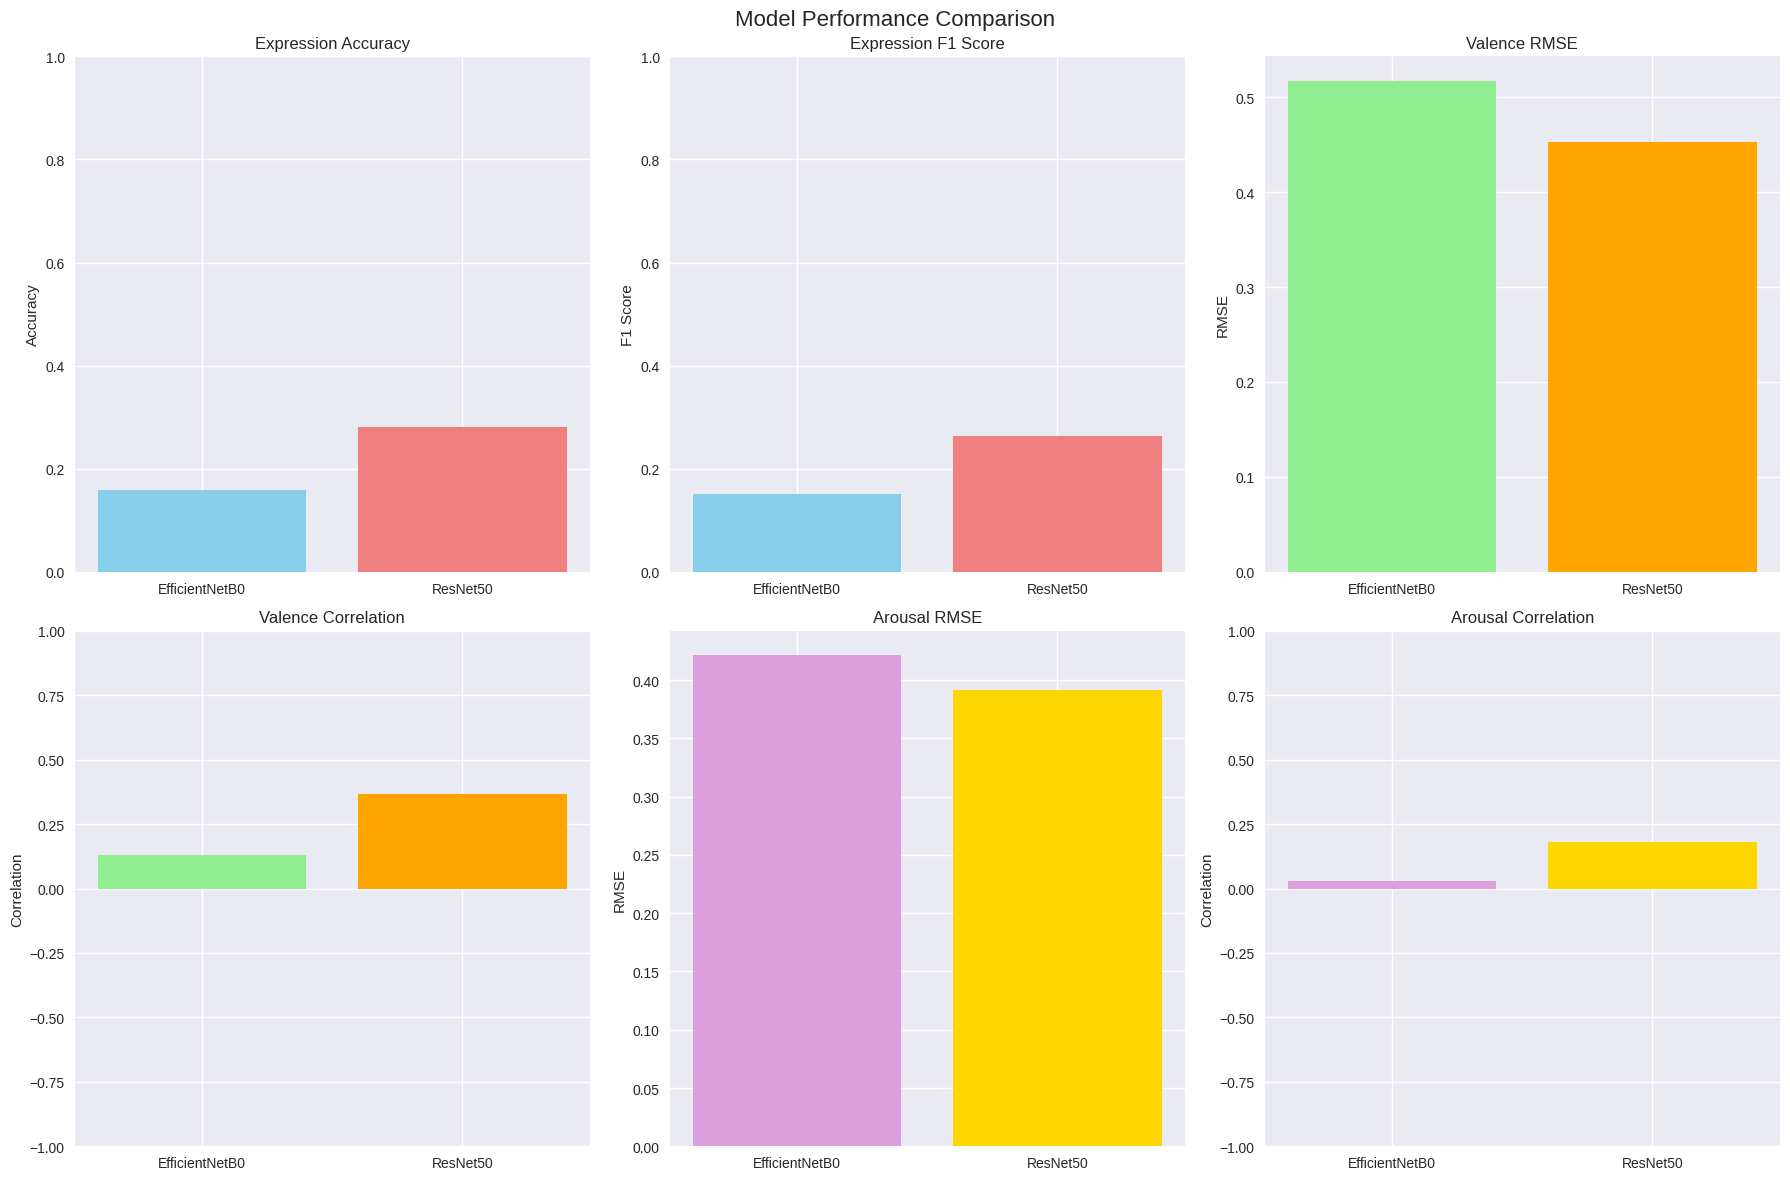


🎯 FINAL SUMMARY:
Best Expression Classification: ResNet50
Accuracy: 0.2812
Best Valence Prediction: ResNet50
Correlation: 0.3652
Best Arousal Prediction: ResNet50
Correlation: 0.1790


In [14]:
# ============================================
# Step 9: Model Evaluation and Results
# ============================================

if len(df) > 0 and len(model_results) > 0:
    print("\n" + "="*80)
    print("🔍 COMPREHENSIVE MODEL EVALUATION")
    print("="*80)

    # Prepare test data for evaluation
    print("Preparing test data...")
    test_data = []
    test_labels = {'expression': [], 'valence': [], 'arousal': []}

    # Use validation set as test set for evaluation
    for idx, row in val_df.iterrows():
        try:
            img = tf.keras.preprocessing.image.load_img(row['image'], target_size=IMG_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            test_data.append(img_array)
            test_labels['expression'].append(row['expression'])
            test_labels['valence'].append(row['valence'])
            test_labels['arousal'].append(row['arousal'])
        except Exception as e:
            print(f"Error loading image {row['image']}: {e}")
            continue

    test_data = np.array(test_data)
    test_labels['expression'] = np.array(test_labels['expression'])
    test_labels['valence'] = np.array(test_labels['valence'])
    test_labels['arousal'] = np.array(test_labels['arousal'])

    print(f"Test data prepared: {len(test_data)} samples")

    # Evaluate each model
    evaluation_results = {}
    for model_name, model in model_results.items():
        print(f"\n Evaluating {model_name}...")
        try:
            results = evaluate_model(model, test_data, test_labels)
            evaluation_results[model_name] = results
            print(f" {model_name} evaluation completed")
        except Exception as e:
            print(f" Error evaluating {model_name}: {e}")

    # Create comprehensive results summary
    if evaluation_results:
        comparison_df = create_results_summary(evaluation_results)

        # Save results to CSV
        comparison_df.to_csv('model_comparison_results.csv', index=False)
        print(f"\n Results saved to 'model_comparison_results.csv'")

        # Create visualization of results
        print(f"\n Creating results visualization...")

        # Plot comparison charts
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16)

        models = list(evaluation_results.keys())

        # Expression Accuracy
        accuracies = [evaluation_results[model]['expression']['accuracy'] for model in models]
        axes[0, 0].bar(models, accuracies, color=['skyblue', 'lightcoral'])
        axes[0, 0].set_title('Expression Accuracy')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(0, 1)

        # Expression F1 Score
        f1_scores = [evaluation_results[model]['expression']['f1_score'] for model in models]
        axes[0, 1].bar(models, f1_scores, color=['skyblue', 'lightcoral'])
        axes[0, 1].set_title('Expression F1 Score')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].set_ylim(0, 1)

        # Valence RMSE
        val_rmse = [evaluation_results[model]['valence']['rmse'] for model in models]
        axes[0, 2].bar(models, val_rmse, color=['lightgreen', 'orange'])
        axes[0, 2].set_title('Valence RMSE')
        axes[0, 2].set_ylabel('RMSE')

        # Valence Correlation
        val_corr = [evaluation_results[model]['valence']['correlation'] for model in models]
        axes[1, 0].bar(models, val_corr, color=['lightgreen', 'orange'])
        axes[1, 0].set_title('Valence Correlation')
        axes[1, 0].set_ylabel('Correlation')
        axes[1, 0].set_ylim(-1, 1)

        # Arousal RMSE
        aro_rmse = [evaluation_results[model]['arousal']['rmse'] for model in models]
        axes[1, 1].bar(models, aro_rmse, color=['plum', 'gold'])
        axes[1, 1].set_title('Arousal RMSE')
        axes[1, 1].set_ylabel('RMSE')

        # Arousal Correlation
        aro_corr = [evaluation_results[model]['arousal']['correlation'] for model in models]
        axes[1, 2].bar(models, aro_corr, color=['plum', 'gold'])
        axes[1, 2].set_title('Arousal Correlation')
        axes[1, 2].set_ylabel('Correlation')
        axes[1, 2].set_ylim(-1, 1)

        plt.tight_layout()
        plt.show()

        # Print final summary
        print(f"\n FINAL SUMMARY:")
        print(f"{'='*50}")
        best_expr_model = max(models, key=lambda x: evaluation_results[x]['expression']['accuracy'])
        best_val_model = max(models, key=lambda x: evaluation_results[x]['valence']['correlation'])
        best_aro_model = max(models, key=lambda x: evaluation_results[x]['arousal']['correlation'])

        print(f"Best Expression Classification: {best_expr_model}")
        print(f"Accuracy: {evaluation_results[best_expr_model]['expression']['accuracy']:.4f}")
        print(f"Best Valence Prediction: {best_val_model}")
        print(f"Correlation: {evaluation_results[best_val_model]['valence']['correlation']:.4f}")
        print(f"Best Arousal Prediction: {best_aro_model}")
        print(f"Correlation: {evaluation_results[best_aro_model]['arousal']['correlation']:.4f}")

    else:
        print("No evaluation results available")

else:
    print("No models available for evaluation. Please run training first.")



QUALITATIVE RESULTS ANALYSIS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


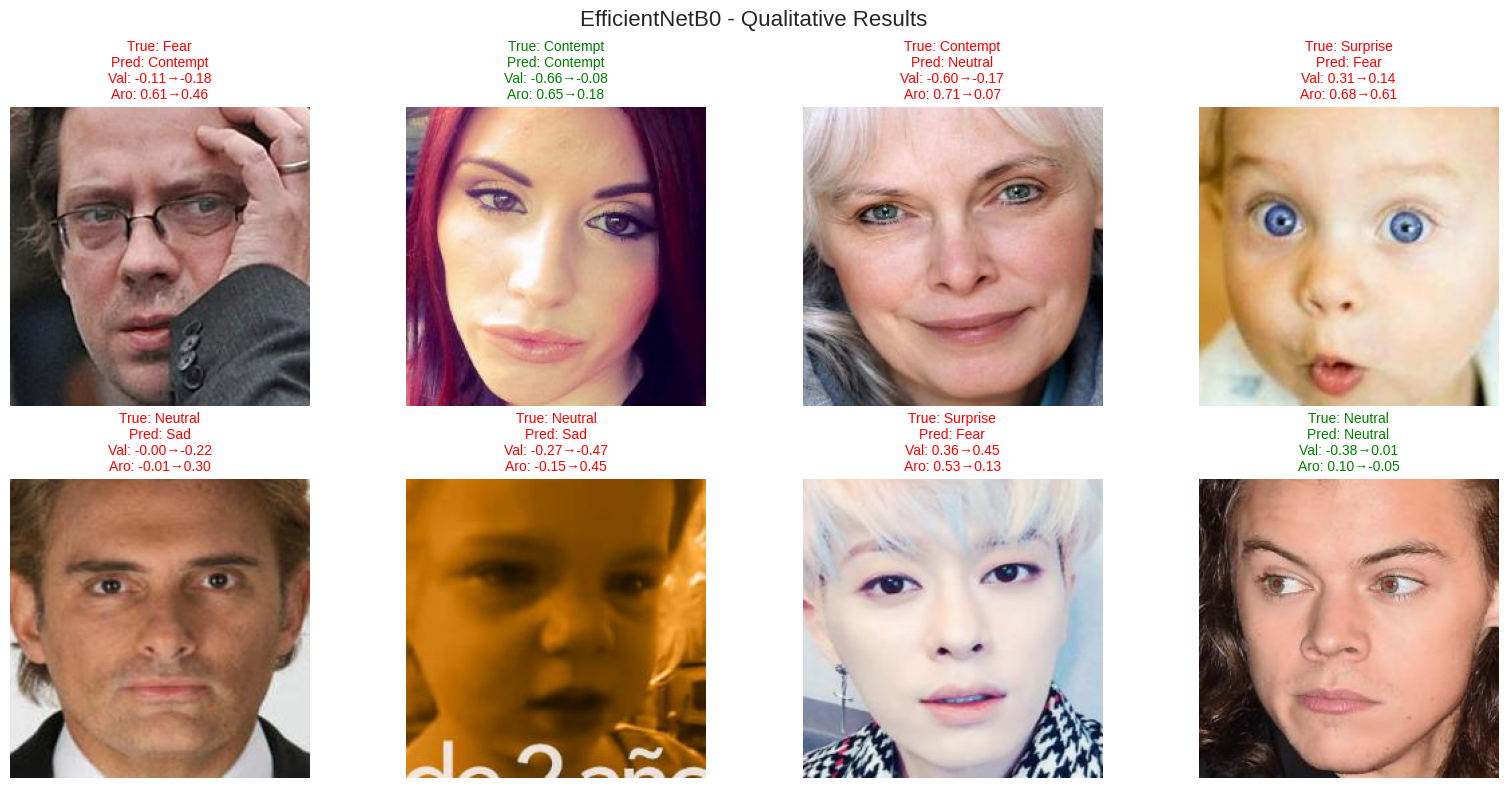


EfficientNetB0 Qualitative Analysis:
   Expression Accuracy: 0.250
   Valence MAE: 0.268
   Arousal MAE: 0.348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


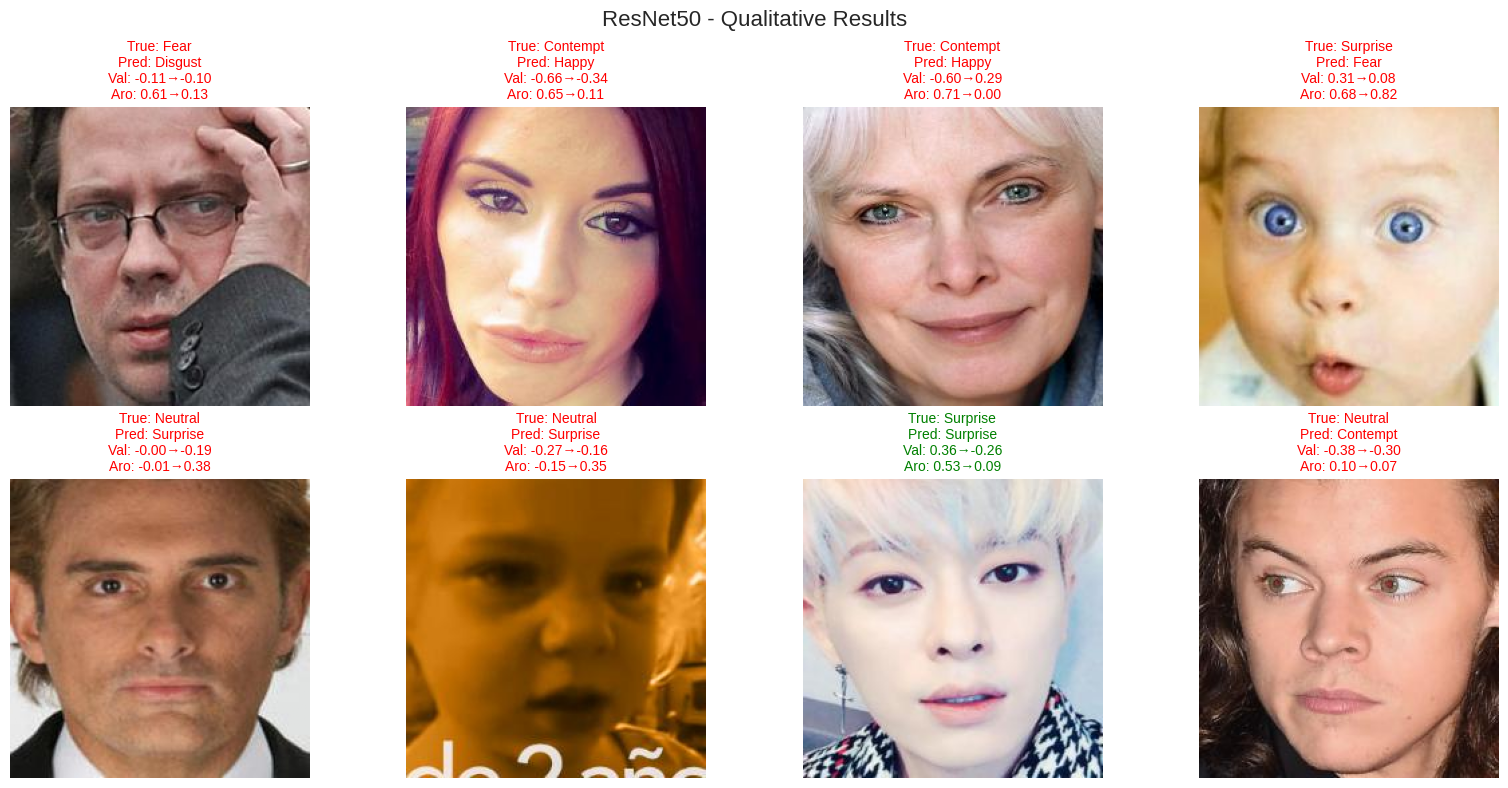


ResNet50 Qualitative Analysis:
   Expression Accuracy: 0.125
   Valence MAE: 0.305
   Arousal MAE: 0.403


In [15]:
# ============================================
# Step 10: Qualitative Results and Documentation
# ============================================

def show_qualitative_results(model, test_data, test_labels, model_name, num_samples=8):
    """
    Show correctly and incorrectly classified samples
    """
    if len(test_data) == 0:
        print("No test data available for qualitative analysis")
        return

    # Get predictions
    predictions = model.predict(test_data[:num_samples])
    expr_pred = np.argmax(predictions[0], axis=1)
    val_pred = predictions[1].flatten()
    aro_pred = predictions[2].flatten()

    # Expression labels
    expr_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'{model_name} - Qualitative Results', fontsize=16)
    axes = axes.flatten()

    for i in range(min(num_samples, len(test_data))):
        # Load and display image
        img = test_data[i]
        axes[i].imshow(img)

        # Get true and predicted labels
        true_expr = test_labels['expression'][i]
        pred_expr = expr_pred[i]
        true_val = test_labels['valence'][i]
        pred_val = val_pred[i]
        true_aro = test_labels['arousal'][i]
        pred_aro = aro_pred[i]

        # Determine if correct
        expr_correct = true_expr == pred_expr
        color = 'green' if expr_correct else 'red'

        # Set title with results
        title = f"True: {expr_labels[true_expr]}\nPred: {expr_labels[pred_expr]}"
        title += f"\nVal: {true_val:.2f}→{pred_val:.2f}"
        title += f"\nAro: {true_aro:.2f}→{pred_aro:.2f}"

        axes[i].set_title(title, color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    expr_accuracy = np.mean(expr_pred == test_labels['expression'][:num_samples])
    val_mae = np.mean(np.abs(val_pred - test_labels['valence'][:num_samples]))
    aro_mae = np.mean(np.abs(aro_pred - test_labels['arousal'][:num_samples]))

    print(f"\n{model_name} Qualitative Analysis:")
    print(f"   Expression Accuracy: {expr_accuracy:.3f}")
    print(f"   Valence MAE: {val_mae:.3f}")
    print(f"   Arousal MAE: {aro_mae:.3f}")

# Show qualitative results if models are available
if len(model_results) > 0 and len(df) > 0:
    print("\n" + "="*80)
    print("QUALITATIVE RESULTS ANALYSIS")
    print("="*80)

    # Prepare a small sample for qualitative analysis
    sample_size = min(16, len(val_df))
    sample_indices = np.random.choice(len(val_df), sample_size, replace=False)

    sample_data = []
    sample_labels = {'expression': [], 'valence': [], 'arousal': []}

    for idx in sample_indices:
        row = val_df.iloc[idx]
        try:
            img = tf.keras.preprocessing.image.load_img(row['image'], target_size=IMG_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            sample_data.append(img_array)
            sample_labels['expression'].append(row['expression'])
            sample_labels['valence'].append(row['valence'])
            sample_labels['arousal'].append(row['arousal'])
        except Exception as e:
            continue

    sample_data = np.array(sample_data)
    sample_labels['expression'] = np.array(sample_labels['expression'])
    sample_labels['valence'] = np.array(sample_labels['valence'])
    sample_labels['arousal'] = np.array(sample_labels['arousal'])

    # Show results for each model
    for model_name, model in model_results.items():
        show_qualitative_results(model, sample_data, sample_labels, model_name, 8)
